In [1]:
# general
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path

import sys
sys.path.append('../../src')

import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *

In [2]:
bm_path = Path('G:/stochastic_bathymetry/raw_data/bedmachine/BedMachineAntarctica-v3.nc')
antgg_path = Path('D:/AntGG2021_allfiles/AntGG2021_Gravity_disturbance_at-surface.nc')
bedmap_path = Path('G:/bedmap/bedmap3_mod.nc')

# MOA: https://nsidc.org/data/nsidc-0730/versions/1
moa_base = Path('G:/stochastic_bathymetry/raw_data/nsidc0730_MEASURES_MOA2014_v01')

# moa coast and grounding line
moa_coast = gpd.read_file(moa_base/'coastlines/moa2014_coastline_v01.shp')
moa_gl = gpd.read_file(moa_base/'coastlines/moa2014_grounding_line_v01.shp')
moa_island = gpd.read_file(moa_base/'coastlines/moa2014_islands_v01.shp')

glkm = moa_gl.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
coastkm = moa_coast.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
islandkm = moa_island.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

In [3]:
region_abbot = [-2.05e6, -1.7e6, -0.5e6, 0.15e6]

ds = bedmachine_grid(bm_path, region_abbot, 5000)

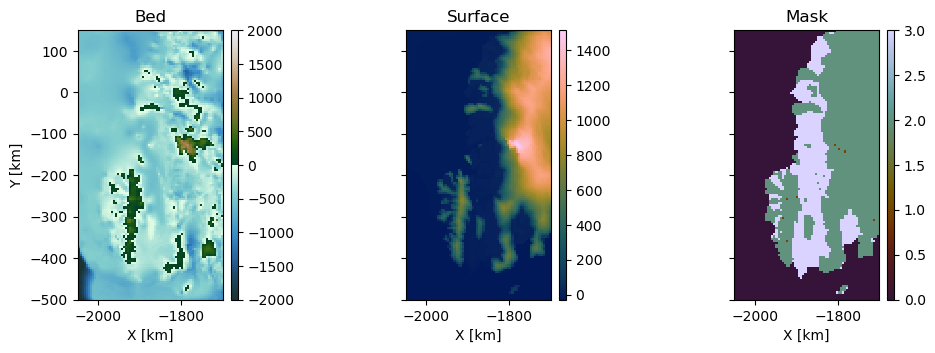

In [4]:
bedmachine_plots(ds, figsize=(12,3.5))

In [5]:
surface, upcon = antgg_grid_from_bm(antgg_path, ds, max_height=1500)

  0%|          | 0/16 [00:00<?, ?it/s]

Best score: 0.9870405421247963
Best parameters: {'damping': 1, 'depth': 5000.0}


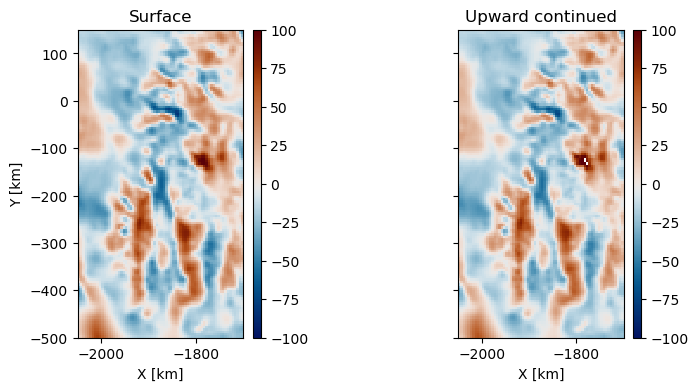

In [6]:
plot_gravity(ds, surface, upcon, 1500, (9,4), 100)

In [7]:
ds = ds.assign_attrs(res=5000)
xx, yy = np.meshgrid(ds.x.values, ds.y.values)
inv_msk = np.where(ds.mask==3, True, False)
inv_pad = vd.distance_mask((xx[inv_msk==True], yy[inv_msk]), 20e3, (xx, yy))

ds['inv_msk'] = (('y', 'x'), inv_msk)
ds['inv_pad'] = (('y', 'x'), inv_pad)

In [8]:
ds['grav_surface'] = (('y', 'x'), surface)
ds['grav_1500'] = (('y', 'x'), upcon)
ds.to_netcdf(Path('abbot.nc'))

In [9]:
xx, yy = np.meshgrid(ds.x.values, ds.y.values)
grav_mask = ds.surface.values < 1500

grav = pd.DataFrame({
    'x' : xx[grav_mask],
    'y' : yy[grav_mask],
    'height' : np.full(xx[grav_mask].size, 1500),
    'faa' : ds.grav_1500.values[grav_mask],
    'inv_msk' : ds.inv_msk.values[grav_mask],
    'inv_pad' : ds.inv_pad.values[grav_mask]
})

In [10]:
grav.to_csv('abbot_grav.csv', index=False)